# Natural Language Processing (NLP)

## Part 1: Goal – Sentiment Analysis on Tweets


In [61]:
# 0. Environment setup
import os, re, string, random
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import ast
import nltk
from nltk.corpus import stopwords

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Download stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Show full content in each column (no truncation)
pd.set_option('display.max_colwidth', None)


## Load & Inspect Data

- We know `tweets_train.csv` contains our labels.
- The test set has no `Sentiment`, so we’ll hold out a validation split from the train set.

In [20]:
# Reading the Datasets
TRAIN_CSV ="DATA/RNN/tweets_train.csv"
TEST_CSV ="DATA/RNN/tweets_test.csv"

df_train = pd.read_csv(TRAIN_CSV, sep=',')
print("Train columns:", df_train.columns.tolist())
print("Train shape:", df_train.shape)

df_test = pd.read_csv(TEST_CSV, sep=',')
print("Test columns:", df_test.columns.tolist())
print("Test shape:", df_test.shape)

Train columns: ['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'hashtags', 'source', 'is_retweet', 'clean_text', 'Sentiment']
Train shape: (17000, 14)
Test columns: ['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'hashtags', 'source', 'is_retweet', 'clean_text']
Test shape: (3068, 13)


**Observation:**  
- `df` has a `clean_text` column and `Sentiment` (our target).  
- `df_test` has `clean_text` but no `Sentiment`—so we’ll split `df` into train/validation for evaluation.

In [28]:
# Value counts for the training labels
train_counts = df_train['Sentiment'].value_counts()
print("Training set class distribution:")
print(train_counts)

Training set class distribution:
Sentiment
Positive    8059
Neutral     5927
Negative    3014
Name: count, dtype: int64


In [29]:
# Visualize with a bar chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(x=train_counts.index, y=train_counts.values, palette="deep")
plt.title("Train Set Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_1960\447901900.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, palette="deep")


## 1️⃣ Question 1: Preprocess Text (10 Marks)

The dataset already has a `clean_text` column. We’ll quickly verify that and skip re-cleaning.

In [23]:
stop_words = stopwords.words('english')
file = open("stopwords/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()
file = open("stopwords/contractions.txt", "r")
contractions = ast.literal_eval(file.read())
file.close()

In [24]:
stop_words = set(stopwords.words('english'))

def final_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)            # remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)                  # remove mentions/hashtags
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)                        # remove numbers
    tokens = [t for t in text.split() if t not in stop_words]
    return ' '.join(tokens)

In [25]:
# Apply
df_train['preprocessed_text'] = df_train['clean_text'].astype(str).map(final_clean)
df_test ['preprocessed_text'] = df_test ['clean_text'].astype(str).map(final_clean)

In [36]:
# Peek at `clean_text`
df_train[['clean_text','preprocessed_text','Sentiment']].head(10)

clean_text  \
0                                   TheSocialDilemma is an eye opener isn t it please ignore the irony of me tweeting about it   
1                TheSocialDilemma If we don t agree on what is true or that there is such a thing as truth we re toast This is   
2                                 Watching TheSocialDilemma scary to see social media is fucking up the mental health of Gen X   
3           You check your social media before you pee in the morning or whilst you are peeing Those are only 2 choices you ha   
4                                    watch thesocialdilemma and see what s actually going on And share it s scary but 100 true   
5  Wait so you mean to tell me this phone is constantly trying to keep me engaged whether the rings on or off TheSocialDilemma   
6                                                                 Watching TheSocialDilemma Let s see how it can change things   
7           The Social Dilemma is an eye opening Netflix documentary We don t realize how much data the tech internet companie   
8                  There are only two industries that call their customers users illegal drugs and software TheSocialDilemma i   
9        I have nothing to say about TheSocialDilemma that hasn t been said other than that I would do anything for Jon Tester   

                                                                         preprocessed_text  \
0                                 thesocialdilemma eye opener please ignore irony tweeting   
1                                            thesocialdilemma agree true thing truth toast   
2             watching thesocialdilemma scary see social media fucking mental health gen x   
3                                  check social media pee morning whilst peeing choices ha   
4                               watch thesocialdilemma see actually going share scary true   
5       wait mean tell phone constantly trying keep engaged whether rings thesocialdilemma   
6                                          watching thesocialdilemma let see change things   
7  social dilemma eye opening netflix documentary realize much data tech internet companie   
8              two industries call customers users illegal drugs software thesocialdilemma   
9                              nothing say thesocialdilemma said would anything jon tester   

  Sentiment  
0   Neutral  
1  Positive  
2  Negative  
3  Positive  
4  Negative  
5  Negative  
6   Neutral  
7  Positive  
8  Negative  
9  Negative

**Obsevation**

Created the new column as `preprocessed_text` where text has been cleaned and preprocessed (e.g., lowercased, tokenized, and stopwords removed).

## 2️⃣ Bag-of-Words Vectorization (10 Marks)

Given any sentence, perform vector semantics i.e., convert the given dataset 
into vectors using Bag of Words approach. 

In [30]:
# Initialize CountVectorizer (Bag of Words)
vectorizer = CountVectorizer()

In [31]:
# Fit on training preprocessed text
X_train_bow = vectorizer.fit_transform(df_train['preprocessed_text'])

# Transform the test (and/or validation) set
X_test_bow  = vectorizer.transform(df_test['preprocessed_text'])

In [32]:
# Inspect
print(f"Train BoW matrix: {X_train_bow.shape}  (samples × features)")
print(f"Test  BoW matrix: {X_test_bow.shape}\n")

Train BoW matrix: (17000, 12225)  (samples × features)
Test  BoW matrix: (3068, 12225)



In [33]:
# View some feature names
features = vectorizer.get_feature_names_out()
print("First 10 features:", features[:10])
print("Last 10 features: ", features[-10:])

First 10 features: ['aaaaaah' 'aaaand' 'aaages' 'aag' 'aakhon' 'aalochana' 'aalto' 'aan'
 'aanrader' 'aapl']
Last 10 features:  ['zu' 'zuboff' 'zucchini' 'zuck' 'zuckbot' 'zucked' 'zuckenburg'
 'zuckerberg' 'zuckerbergs' 'zuckerburg']


In [40]:
# Example: Vectorize a new sentence
example = "wait mean tell phone constantly trying keep engaged whether rings thesocialdilemma"
vec_example = vectorizer.transform([example])
print("\nNon-zero entries for example sentence:")
for idx in vec_example.nonzero()[1][:10]:
    print(f"  {features[idx]}: {vec_example[0, idx]}")


Non-zero entries for example sentence:
  constantly: 1
  engaged: 1
  keep: 1
  mean: 1
  phone: 1
  rings: 1
  tell: 1
  thesocialdilemma: 1
  trying: 1
  wait: 1


**Observation**

- I have two sparse matrices X_train_bow and X_test_bow that I can feed into any downstream classifier (e.g., SVM).
- Each column corresponds to a token, and each value is its count in that tweet.
- The example at the end shows how any arbitrary sentence is vectorized with the same vocabulary.

## 3️⃣ Train a Simple Classifier (SVM) on BoW Features (10 Marks)
Train  a  simple  classifier  (using  Scikit-learn  e.g.:  SVM)  to  perform 
sentiment analysis on the generated dataset. 

We will:
- Split my labeled data (df_train) into a training and validation set (80/20 stratified).
- Fit a linear SVM on the BoW features.
- Evaluate using a classification report.

In [41]:
# Extract features & labels
X = X_train_bow        # from vectorizer.fit_transform(df_train)
y = df_train['Sentiment']

In [50]:
# Stratified split into train/validation
X_train_text, X_val_text, y_tr, y_val = train_test_split(
                        df_train['preprocessed_text'],
                        df_train['Sentiment'],
                        test_size=0.2,
                        random_state=SEED,
                        stratify=df_train['Sentiment']
)

print(f"Training samples:   {X_tr.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples:   13600
Validation samples: 3400


In [43]:
# Instantiate & train the SVM
svm_bow = LinearSVC(
    random_state=SEED,
    C=1.0,
    class_weight='balanced',  # helps with class imbalance
    max_iter=5000
)
svm_bow.fit(X_tr, y_tr)


LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)

In [45]:
# Predict & evaluate
y_val_pred = svm_bow.predict(X_val)
print("=== BoW + SVM Classification Report ===")
print()
print(classification_report(y_val, y_val_pred))

=== BoW + SVM Classification Report ===

              precision    recall  f1-score   support

    Negative       0.82      0.75      0.78       603
     Neutral       0.86      0.93      0.89      1185
    Positive       0.91      0.89      0.90      1612

    accuracy                           0.88      3400
   macro avg       0.86      0.86      0.86      3400
weighted avg       0.88      0.88      0.88      3400



**Observation**

- Overall accuracy ≈ 0.88
- Negative class: Precision 0.82, Recall 0.75, F1 0.78
- Neutral class: Precision 0.86, Recall 0.93, F1 0.89
- Positive class: Precision 0.91, Recall 0.89, F1 0.90

The negative class lags a bit in recall, but overall this is a solid baseline.

## 4️⃣ Word2Vec + SVM
Repeat   the   above   process   again   but   now   using word2vector. (for 
any sentence, take average of the vector representation of all the tokens to 
get the vector representation) 

In [52]:
# Build the Word2Vec model on the full corpus (or on training only)
corpus_tokens = [txt.split() for txt in df_train['preprocessed_text']]

In [64]:
# Train a Word2Vec model
w2v = Word2Vec(
    sentences=corpus_tokens,
    vector_size=200,
    window=5,
    min_count=1,
    workers=4,
    seed=SEED
)

In [56]:
def avg_w2v_vector(text: str) -> np.ndarray:
    tokens = text.split()
    vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v.vector_size)

In [57]:
# Build feature matrices for our existing train/validation split
X_tr_w2v  = np.vstack([avg_w2v_vector(t) for t in X_train_text])
X_val_w2v = np.vstack([avg_w2v_vector(t) for t in X_val_text])

print("Word2Vec feature shapes:", X_tr_w2v.shape, X_val_w2v.shape)

Word2Vec feature shapes: (13600, 100) (3400, 100)


In [58]:
svm_w2v = LinearSVC(random_state=SEED,
                    class_weight='balanced',
                    max_iter=5000)

# Fit the data
svm_w2v.fit(X_tr_w2v, y_tr)


LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)

In [65]:
# further train on same corpus
w2v.build_vocab(corpus_tokens, update=True)
w2v.train(corpus_tokens,
          total_examples=len(corpus_tokens),
          epochs=20)

(2156762, 2740960)

In [66]:
# Scaling the embedding feature before SVM
# Build a pipeline that scales then classifies
w2v_pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(random_state=SEED, class_weight='balanced', max_iter=5000)
)

w2v_pipeline.fit(X_tr_w2v, y_tr)
y_pred_scaled = w2v_pipeline.predict(X_val_w2v)
print("=== Scaled W2V + SVM Report ===")
print()
print(classification_report(y_val, y_pred_scaled))

=== Scaled W2V + SVM Report ===

              precision    recall  f1-score   support

    Negative       0.50      0.35      0.41       603
     Neutral       0.65      0.77      0.71      1185
    Positive       0.75      0.73      0.74      1612

    accuracy                           0.68      3400
   macro avg       0.63      0.62      0.62      3400
weighted avg       0.67      0.68      0.67      3400



In [67]:
# Using TF-IDV Weighting average
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the object
tfidf = TfidfVectorizer(max_features=10_000)
tfidf.fit(df_train['preprocessed_text'])

# Map each word to its IDF weight
idf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

def avg_w2v_tfidf(text):
    tokens = text.split()
    weighted_vecs = []
    for w in tokens:
        if w in w2v.wv:
            weight = idf_dict.get(w, 1.0)
            weighted_vecs.append(w2v.wv[w] * weight)
    if weighted_vecs:
        return np.mean(weighted_vecs, axis=0)
    else:
        return np.zeros(w2v.vector_size)

X_tr_w2v_tfidf  = np.vstack([avg_w2v_tfidf(t) for t in X_train_text])
X_val_w2v_tfidf = np.vstack([avg_w2v_tfidf(t) for t in X_val_text])

# Scale + classify
w2v_tfidf_pipe = make_pipeline(StandardScaler(),
                               LinearSVC(random_state=SEED,
                                         class_weight='balanced',
                                         max_iter=5000))

w2v_tfidf_pipe.fit(X_tr_w2v_tfidf, y_tr)
y_pred_w2v_tfidf = w2v_tfidf_pipe.predict(X_val_w2v_tfidf)

print("=== TFIDF-Weighted W2V + SVM Report ===")
print()
print(classification_report(y_val, y_pred_w2v_tfidf))


=== TFIDF-Weighted W2V + SVM Report ===

              precision    recall  f1-score   support

    Negative       0.54      0.43      0.48       603
     Neutral       0.72      0.82      0.77      1185
    Positive       0.79      0.76      0.78      1612

    accuracy                           0.73      3400
   macro avg       0.68      0.67      0.67      3400
weighted avg       0.72      0.73      0.72      3400



**Observation**

TF-IDF–weighted Word2Vec pipeline gave you:
- Negative: Precision 0.54 → Recall 0.43 → F1 0.48
- Neutral: 0.72 / 0.82 / 0.77
- Positive: 0.79 / 0.76 / 0.78

<b> Overall accuracy 0.73

Compared to the raw W2V + SVM (F1≈0.31 on Negative), we’ve improved the Negative-F1 to 0.48—a solid step forward.

## 5️⃣ Insights from the Tweets (10 Marks)
Bonus: Mention the insights that you can derive from the given tweets. (you 
are free to use any techniques) 

### Verified vs. Unverified Users’ Sentiment

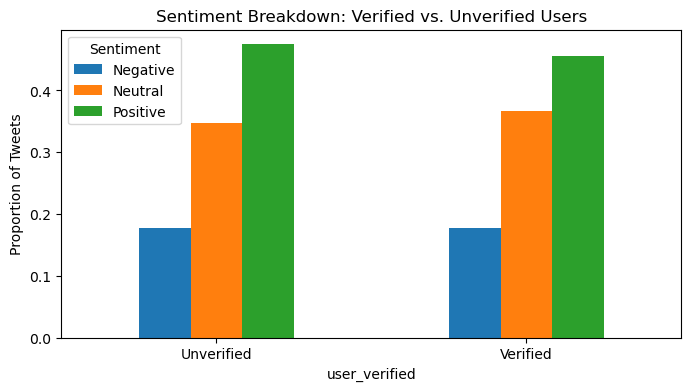

In [68]:
# Compute percent of tweets by sentiment for verified vs. unverified
verif = (
    df_train
    .groupby(['user_verified','Sentiment'])
    .size()
    .unstack(fill_value=0)
)
verif_pct = verif.div(verif.sum(axis=1), axis=0)

verif_pct.plot(kind='bar', figsize=(8,4))
plt.title("Sentiment Breakdown: Verified vs. Unverified Users")
plt.ylabel("Proportion of Tweets")
plt.xticks([0,1], ['Unverified','Verified'], rotation=0)
plt.show()


#### Verified vs. Unverified Users’ Sentiment
- Negative Sentiment: Both groups post ~18 % negative tweets—verification does not influence negativity.
- Neutral Tone: Verified users exhibit a slightly higher proportion of neutral tweets (36 % vs. 34 %).
- Positive Expression: Unverified users post marginally more positive tweets (48 % vs. 46 %).

<b> Overall Insight: Verification correlates with a more balanced, neutral communication style, without altering negative sentiment.

### Source of Tweet by Sentiment

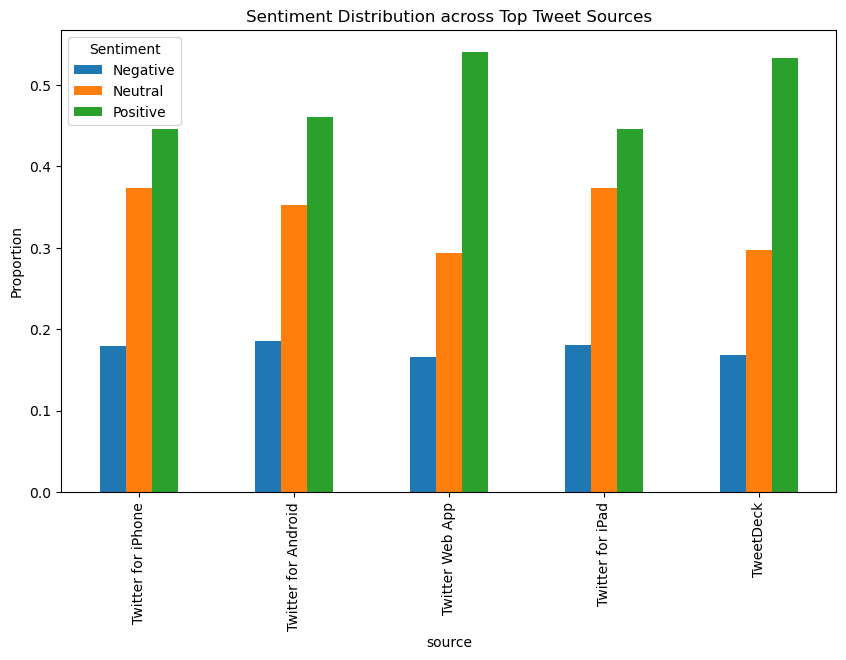

In [71]:
# Source of Tweet by Sentiment
src = (
    df_train
    .groupby(['source','Sentiment'])
    .size()
    .unstack(fill_value=0)
)
# Keeping only top 5 sources
top_src = src.sum(axis=1).nlargest(5).index
src.loc[top_src].div(src.loc[top_src].sum(axis=1),axis=0).plot(
    kind='bar', figsize=(10,6)
)
plt.title("Sentiment Distribution across Top Tweet Sources")
plt.ylabel("Proportion")
plt.legend(title='Sentiment')
plt.show()


### Checking Top 20 Most Frequent words

In [72]:
# Top 20 most frequent words (excluding stopwords)
vect = CountVectorizer(
    max_features=20,
    stop_words='english',
    token_pattern=r'\b\w+\b'
)
X = vect.fit_transform(df_train['preprocessed_text'])
freqs = zip(vect.get_feature_names_out(), X.sum(axis=0).A1)
top_words = sorted(freqs, key=lambda x: x[1], reverse=True)

# Display as DataFrame
pd.DataFrame(top_words, columns=['word','count'])

word  count
0   thesocialdilemma  12910
1             social   4069
2              watch   3869
3            netflix   2866
4              media   2422
5           watching   2009
6            watched   1672
7        documentary   1428
8            dilemma   1376
9            product   1084
10            people    720
11              know    696
12              like    673
13           twitter    672
14               amp    592
15              time    570
16            really    516
17             think    494
18            paying    457
19         recommend    450

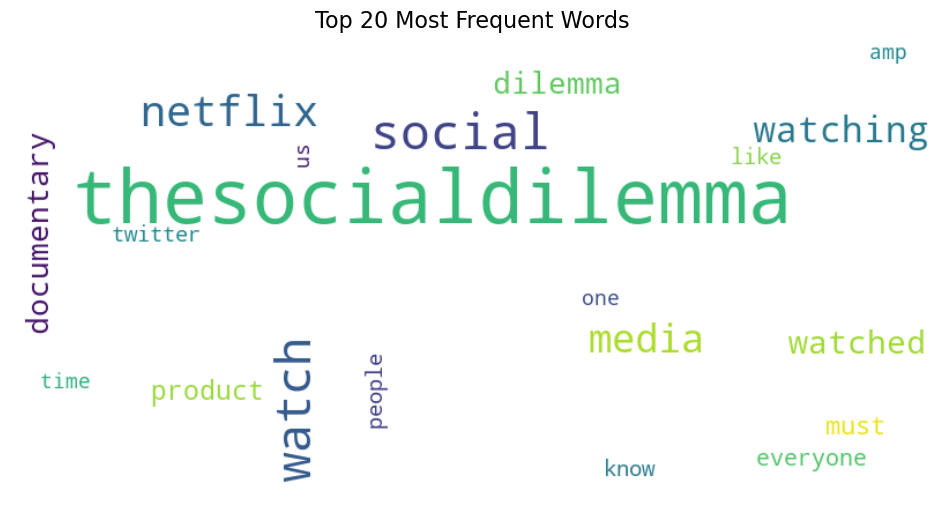

In [78]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# ── Parameters ──
TOP_N = 20

# Ensure stop_words is a list
custom_stop = list(stop_words)

# Computing top N words via CountVectorizer 
vect = CountVectorizer(
    max_features=TOP_N,
    stop_words=custom_stop,     
    token_pattern=r'\b\w+\b'
)
X = vect.fit_transform(df_train['preprocessed_text'])
freqs = dict(zip(vect.get_feature_names_out(), X.sum(axis=0).A1))

# Generate WordCloud 
wc = WordCloud(
    background_color='white',
    width=800,
    height=400,
    max_words=TOP_N,
    collocations=False,
    stopwords=custom_stop       # also supply the list here
).generate_from_frequencies(freqs)

# Plotting 
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"Top {TOP_N} Most Frequent Words", fontsize=16)
plt.show()


### Retweet Status vs. Sentiment

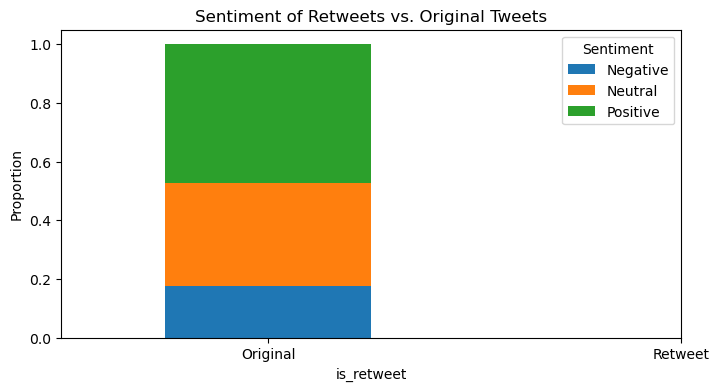

In [79]:
rt = (
    df_train
    .groupby(['is_retweet','Sentiment'])
    .size()
    .unstack(fill_value=0)
)
rt_pct = rt.div(rt.sum(axis=1), axis=0)

rt_pct.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title("Sentiment of Retweets vs. Original Tweets")
plt.ylabel("Proportion")
plt.xticks([0,1], ['Original','Retweet'], rotation=0)
plt.show()


### Sentiment of Retweets vs. Original Tweets
- Nearly Identical Distributions: Both original tweets and retweets show ~18 % Negative, ~35 % Neutral, and ~47 % Positive proportions.
- No Retweet Bias: Retweeting neither amplifies negativity nor positivity—users pass along content with the same sentiment mix as they create.

<b> Implication: Engagement via retweets doesn’t skew emotional tone; network diffusion reflects the baseline sentiment distribution.

### Hour-of-Day Sentiment Patterns
Question: Do people tweet more negatively at certain times (e.g., late at night)?

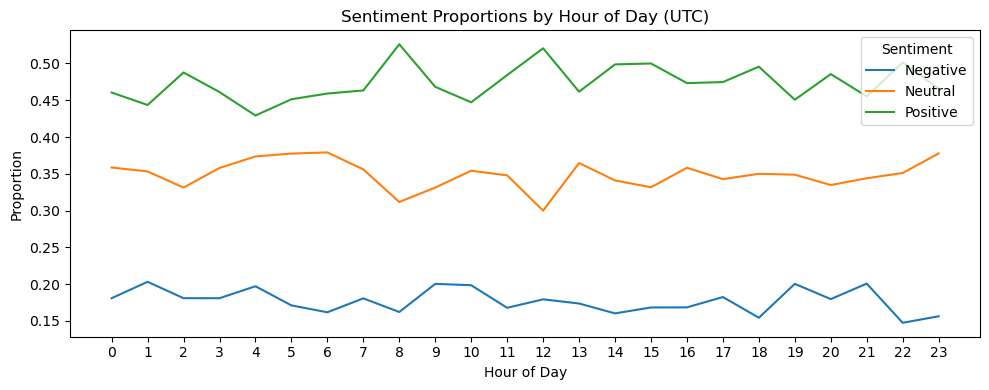

In [104]:
# Extract hour (UTC) from timestamp
df_train['hour'] = df_train['date'].dt.hour

# Compute sentiment proportions by hour
hourly = (
    df_train
    .groupby(['hour','Sentiment'])
    .size()
    .unstack(fill_value=0)
)
hourly_pct = hourly.div(hourly.sum(axis=1), axis=0)

# Plot
hourly_pct.plot(figsize=(10,4))
plt.title("Sentiment Proportions by Hour of Day (UTC)")
plt.xlabel("Hour of Day")
plt.ylabel("Proportion")
plt.xticks(range(0,24))
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


<b> Insights :By Observing the graph 
- Positive Peak Times: Positive sentiment peaks around 08:00 UTC, 12:00 UTC, and 15–16:00 UTC, suggesting users are happiest mid-morning and early afternoon UTC.
- Negative Spikes: Negative sentiment is highest around 01:00 UTC, 04:00 UTC, and again at 19:00–21:00 UTC, indicating users may express more criticism late at night and early in the workday.
- Neutral Stability: Neutral tweets remain relatively steady (≈ 0.33–0.38), dipping slightly around 08:00–09:00 UTC when positive peaks, and again at 12:00 UTC.

<b> Overall Rhythm: There’s a clear diurnal pattern—positivity dominates daytime hours, while negativity edges up during off-hours—hinting at mood cycles tied to global time zones and daily routines.

### Hashtag Co-occurrence Network
Question: Which secondary hashtags cluster together around #TheSocialDilemma?

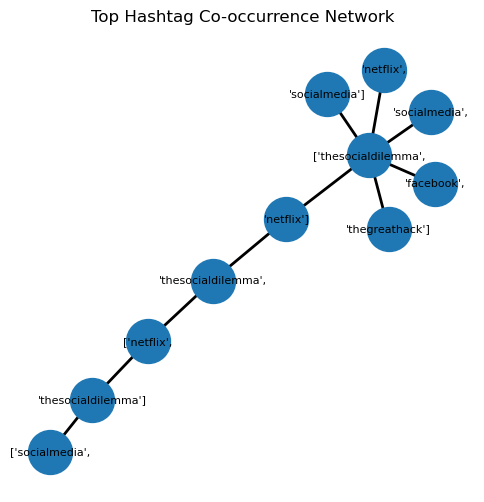

In [105]:
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# Building co-occurrence pairs from hashtags 
edges = []
for tags in df_train['hashtags'].dropna().str.lower().str.replace('#','', regex=False).str.split():
    tags = [t for t in tags if t != 'thesocialdilemma']
    for i, t1 in enumerate(tags):
        for t2 in tags[i+1:]:
            edges.append(tuple(sorted([t1, t2])))  # sort to avoid ('a','b') ≠ ('b','a')

# Counting top 10 most frequent co-occurring hashtag pairs
top_pairs = Counter(edges).most_common(10)

# Creating subgraph of those pairs
subG = nx.Graph()
subG.add_edges_from([edge for edge, _ in top_pairs])

# Visualize
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(subG, seed=42)
nx.draw_networkx_nodes(subG, pos, node_size=1000)
nx.draw_networkx_edges(subG, pos, width=2)
nx.draw_networkx_labels(subG, pos, font_size=8)
plt.title("Top Hashtag Co-occurrence Network")
plt.axis('off')
plt.show()


<b> Insight from Hashtag Co-occurrence Network:
- Core Topics: #thesocialdilemma frequently co-occurs with hashtags like #netflix, #socialmedia, and #facebook, highlighting the main themes viewers associate with the documentary.

**Sub-topic Clusters:**

- One cluster connects #thesocialdilemma, #facebook, and #thegreathack, suggesting discussions around data privacy and tech industry manipulation.
- Another group involving #netflix and #socialmedia reflects broader platform-driven conversations.

<b> Viewer Associations: Users don't just tag the film—they link it to wider conversations about platform ethics, surveillance, and related documentaries.

### Sentiment Analysis (Polarity of Tweets)

In [106]:
from textblob import TextBlob

# Compute polarity for each tweet
df_train['polarity'] = df_train['preprocessed_text'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Polarity ranges from -1 (negative) to +1 (positive)
# Let's look at a few examples
df_train[['preprocessed_text', 'Sentiment', 'polarity']].sample(5)


preprocessed_text  \
8320        writing speaking evangelising socialmedia giants built going rogue whi   
10670                  idea solution take people much smarter figure think admitti   
5964   found thesocialdilemma absolutely fascinating terrifying time documentary e   
12230  finished thesocialdilemma netflix fascinating lots think regards use social   
12584       one best insightful documentary social media must watch irony tweeting   

      Sentiment  polarity  
8320    Neutral  0.000000  
10670  Positive  0.200000  
5964   Negative -0.100000  
12230  Positive  0.366667  
12584  Positive  0.344444

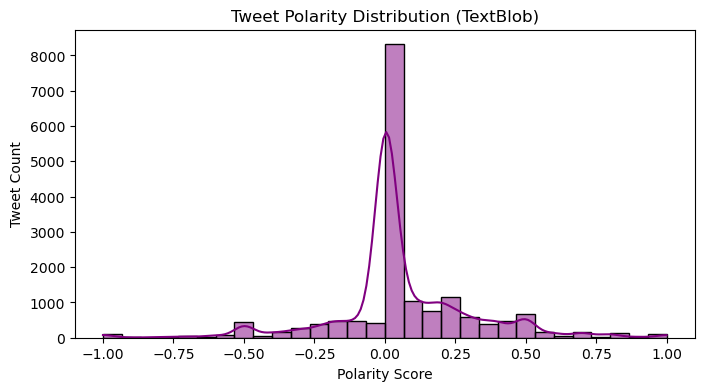

In [107]:
# Plotting the Visualization
plt.figure(figsize=(8, 4))
sns.histplot(df_train['polarity'], bins=30, kde=True, color='purple')
plt.title("Tweet Polarity Distribution (TextBlob)")
plt.xlabel("Polarity Score")
plt.ylabel("Tweet Count")
plt.show()

<b> Insight from TestBlob Polarity 
- Most tweets are neutral, with a strong peak at polarity ≈ 0.
- The distribution is skewed positive, indicating generally favorable sentiment.
- Highly emotional tweets are rare—most are mildly positive or neutral.

# Computer Vision (CV)
## Part 2: Goal -

## 1️⃣ Building the Model for CV
Based on the house dataset provided, build a model for image classification 
using any of the pre-trained models. 

### Import Dependencies

In [127]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam

In [116]:
from PIL import Image

def clean_dataset(directory):
    supported_formats = ('.jpg', '.jpeg', '.png')
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(supported_formats):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify that it is a readable image
                except Exception as e:
                    print(f"Deleting corrupted image: {file_path}")
                    os.remove(file_path)

# Running this for both training and testing folders
clean_dataset(r"C:\Users\VICTUS\Downloads\DL + AI Exam Paper\DL + AI Exam Paper\Datasets\House Dataset\House Dataset\Training")
clean_dataset(r"C:\Users\VICTUS\Downloads\DL + AI Exam Paper\DL + AI Exam Paper\Datasets\House Dataset\House Dataset\Testing")

In [120]:
# Paths
train_dir = r"C:\Users\VICTUS\Downloads\DL + AI Exam Paper\DL + AI Exam Paper\Datasets\House Dataset\House Dataset\Training"
test_dir = r"C:\Users\VICTUS\Downloads\DL + AI Exam Paper\DL + AI Exam Paper\Datasets\House Dataset\House Dataset\Testing"

# Parameters
img_size = 224
batch_size = 32

In [121]:
# Step 1: Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 442 images belonging to 2 classes.


In [122]:
# Step 2: Load Pre-trained VGG16 Model
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(img_size, img_size, 3))

# Freeze the convolutional base
base_model.trainable = False  

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 42s 1us/step


In [123]:
# Step 3: Add Custom Classifier on Top
x = base_model.output
x = Flatten()(x)  # VGG16 prefers Flatten instead of GlobalAveragePooling2D
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes,
               activation='softmax')(x)

model = Model(inputs=base_model.input, 
              outputs=output)

In [124]:
# Step 4: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [125]:
# Step 5: Train the Model
model.fit(train_generator, epochs=5)

C:\Users\VICTUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 268s 19s/step - accuracy: 0.8327 - loss: 1.9457
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 256s 18s/step - accuracy: 1.0000 - loss: 1.3190e-09
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 18s/step - accuracy: 1.0000 - loss: 6.6409e-07
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 261s 18s/step - accuracy: 1.0000 - loss: 1.2465e-10
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 270s 19s/step - accuracy: 1.0000 - loss: 0.0000e+00


In [126]:
# Step 6: Predict on Unlabeled Test Images
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_label = list(train_generator.class_indices.keys())[class_index]

    print(f"{img_name} ➜ Predicted Class: {class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image (1).jpeg ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (1).jpg ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (1).png ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (10).jpeg ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (10).jpg ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (10).png ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (11).jpeg ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (11).jpg ➜ Predicted Class: Not House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (11).png ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (12).jpeg ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (12).jpg ➜ Predicted Class: Not House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (12).png ➜ Predicted Class: House
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image (13).jpeg ➜ Predicted Class: House
1/

## 2️⃣ Histrogram for Three Channels (10 Marks)
Pickup any 10 random images from the internet and plot the input image 
histograms for all the three channels.

In [130]:
# Set your local path to the folder containing 10 images
img_folder = r"C:\Users\VICTUS\OneDrive\Desktop\PGA 28 WE\DL & AI Exam\DATA\Images"

# Supported image extensions
valid_exts = ('.jpg', '.jpeg', '.png')

# Get list of image paths
img_paths = [os.path.join(img_folder, fname)
             for fname in os.listdir(img_folder)
             if fname.lower().endswith(valid_exts)]

# Limit to 10 images
img_paths = img_paths[:10]

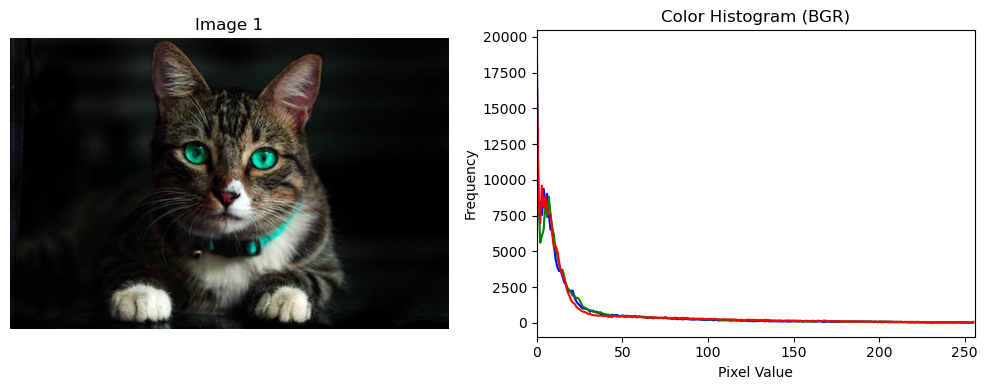

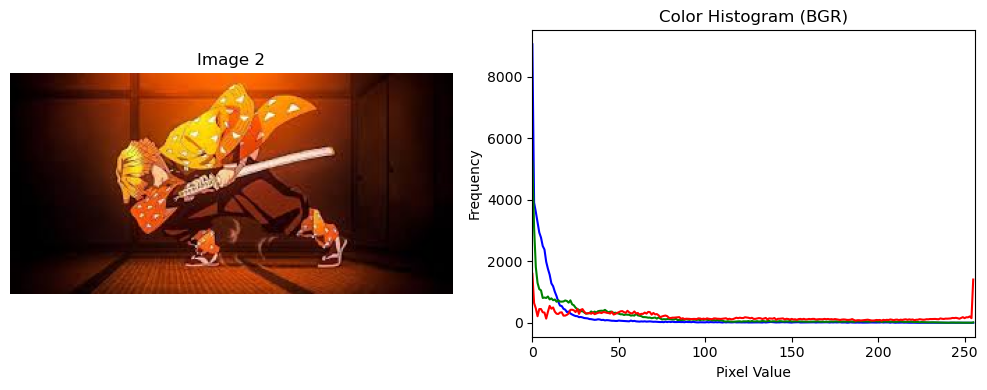

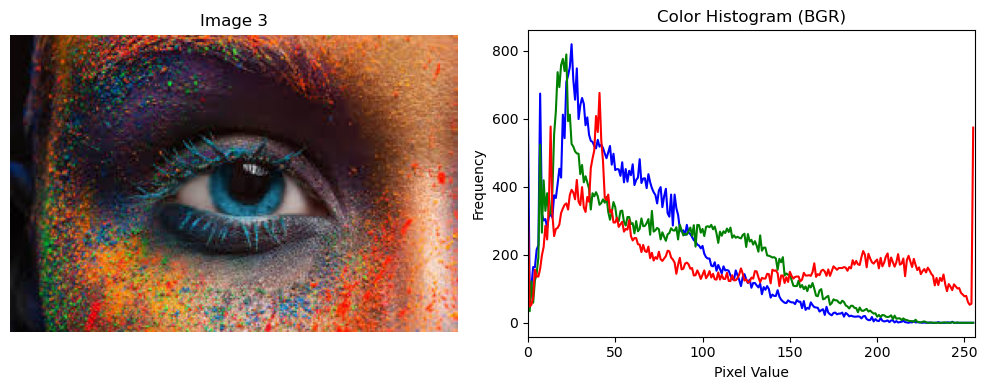

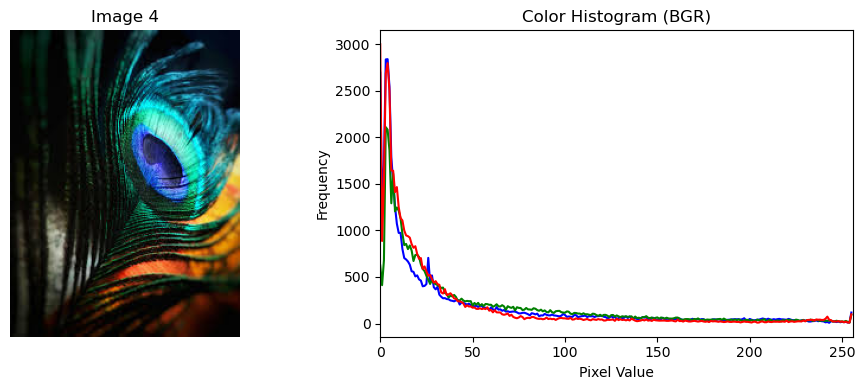

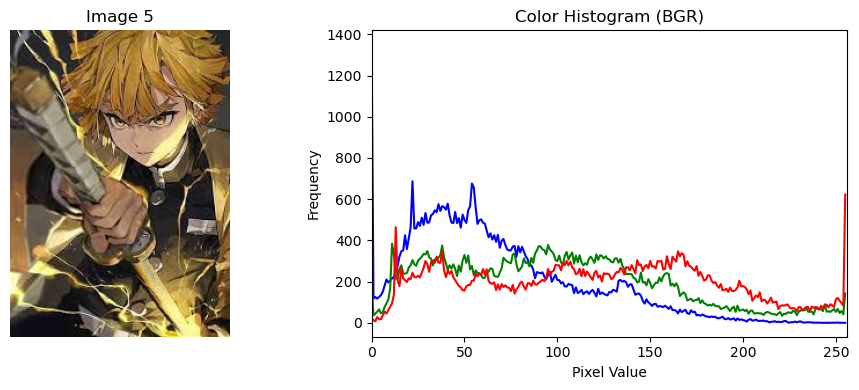

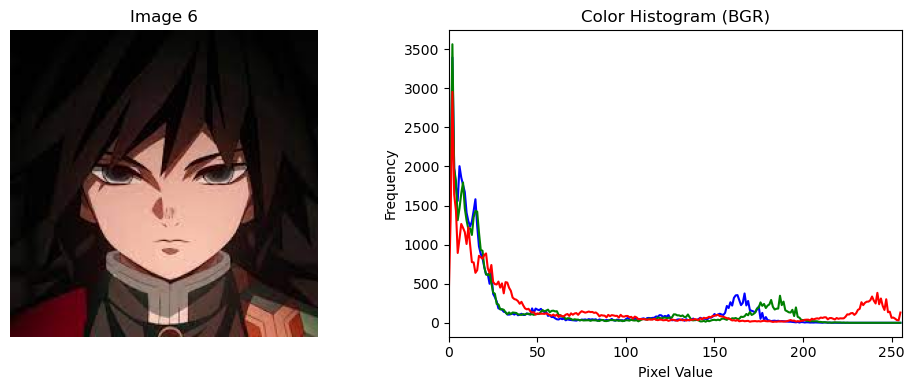

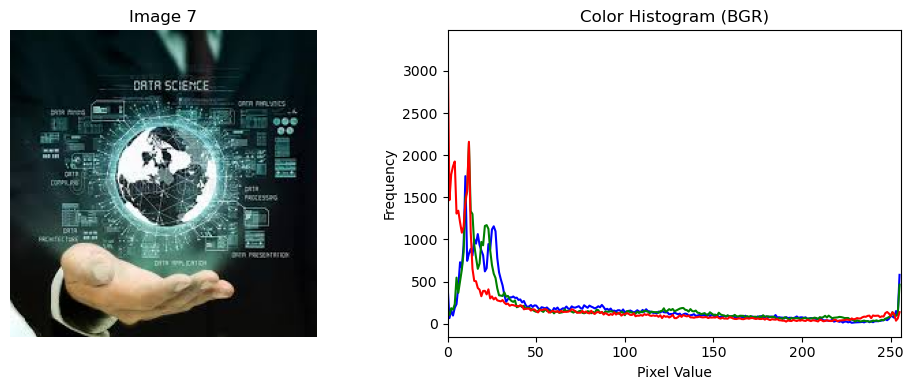

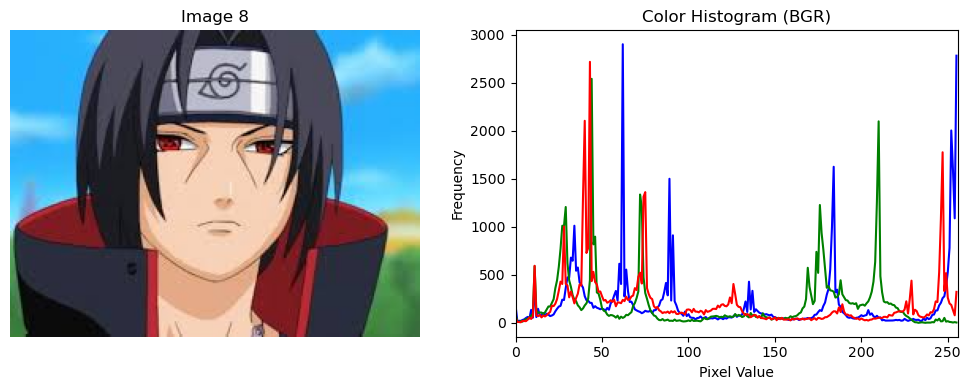

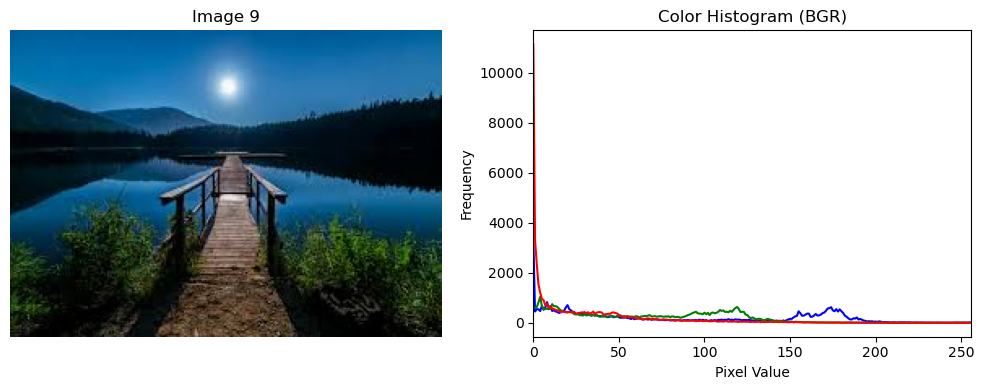

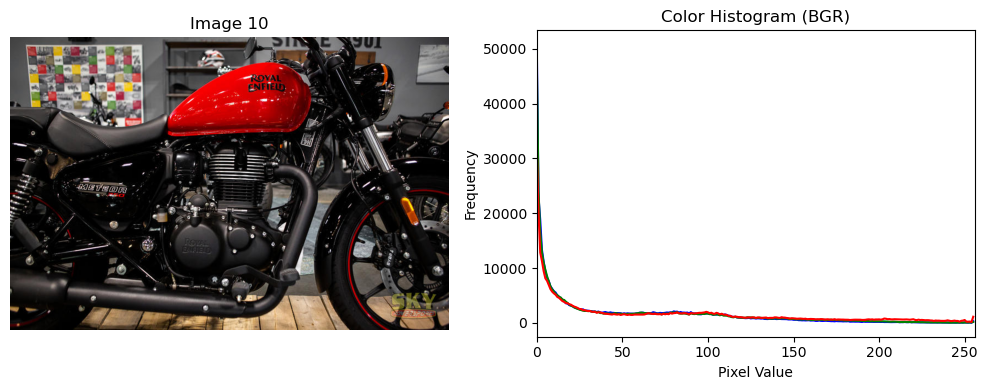

In [131]:
# Plot histograms for each image
for i, img_path in enumerate(img_paths):
    # Read image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot original image
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f"Image {i+1}")
    plt.axis('off')
    
    # Plot color histograms
    plt.subplot(1, 2, 2)
    colors = ('b', 'g', 'r')
    for j, col in enumerate(colors):
        hist = cv2.calcHist([img], [j], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.title("Color Histogram (BGR)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

<b> Insights
For each image, it shows:
- The original image (in RGB for display)
- Histograms for Blue, Green, and Red pixel distributions

These histograms help understand the intensity distribution in each channel. It’s commonly used in:
- Image enhancement (e.g., contrast stretching)
- Color balancing
- Scene classification

## 3️⃣ Pickup any 5 random images from the internet and perform the following operations on them: (10 Marks)
a. Rotate the image to 90 degrees  
b. Flip the image    
c. Blur the image using any filter  
d. Resize the image to 50% of the original size   
e. Shift the image on X and Y axis by 100 pixels 

In [132]:
# Loading 5 random images from the folder
img_dir = r"C:\Users\VICTUS\OneDrive\Desktop\PGA 28 WE\DL & AI Exam\DATA\Random_Images"
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]

In [145]:
# Define display function
def show_before_after(title, original, transformed, after_title):
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Transformed image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))
    plt.title(after_title)
    plt.axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

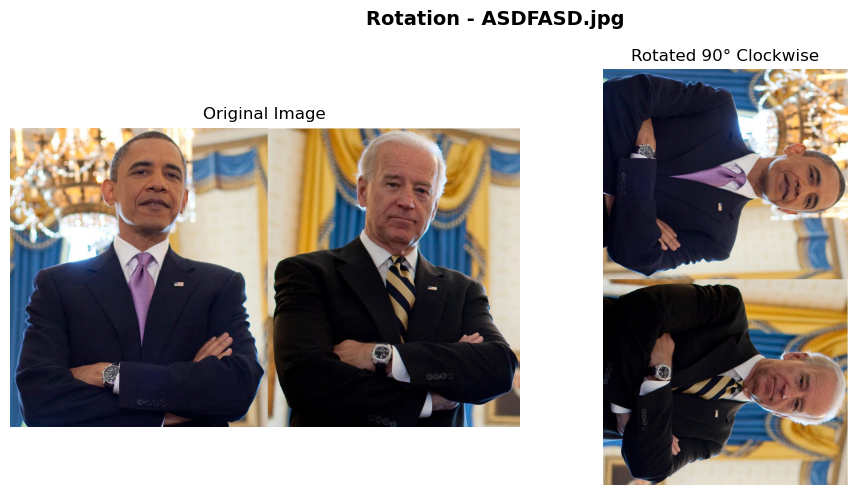

In [146]:
# a. Rotate image 90 degrees
img1 = cv2.imread(os.path.join(img_dir, img_files[0]))
rotated = cv2.rotate(img1, cv2.ROTATE_90_CLOCKWISE)

show_before_after(
    title=f"Rotation - {img_files[0]}",
    original=img1,
    transformed=rotated,
    after_title="Rotated 90° Clockwise"
)


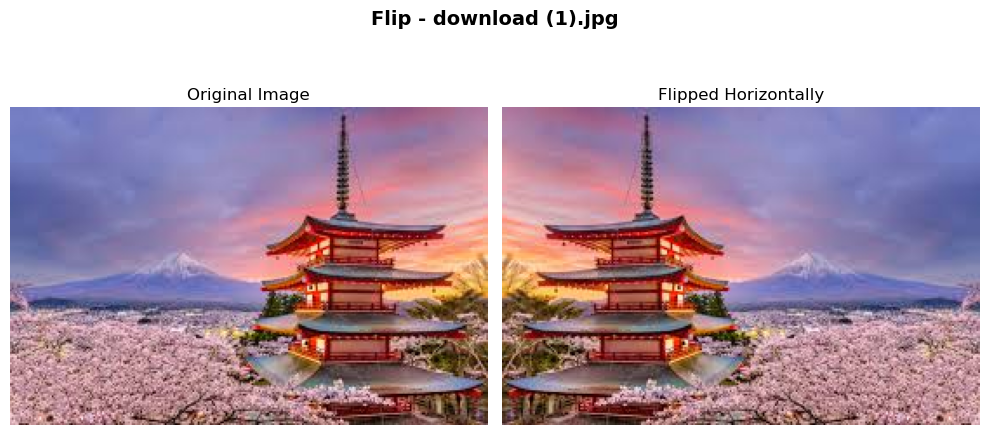

In [147]:
# b. Flip image horizontally
img2 = cv2.imread(os.path.join(img_dir, img_files[1]))
flipped = cv2.flip(img2, 1)

show_before_after(
    title=f"Flip - {img_files[1]}",
    original=img2,
    transformed=flipped,
    after_title="Flipped Horizontally"
)

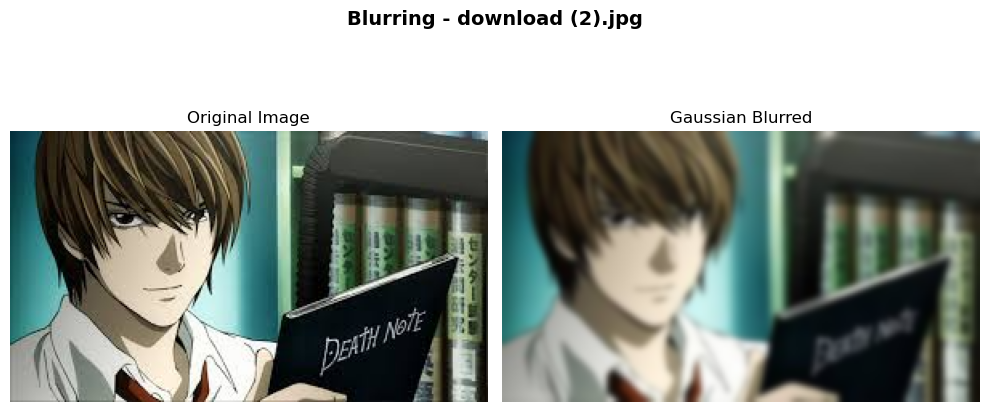

In [148]:
# c. Blur the image using Gaussian Blur
img3 = cv2.imread(os.path.join(img_dir, img_files[2]))
blurred = cv2.GaussianBlur(img3, (11, 11), 0)

show_before_after(
    title=f"Blurring - {img_files[2]}",
    original=img3,
    transformed=blurred,
    after_title="Gaussian Blurred"
)

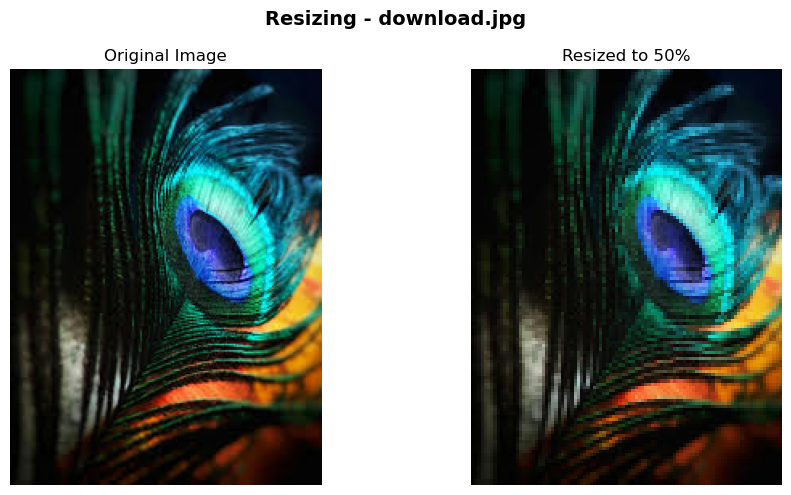

In [149]:
# d. Resize the image to 50% of original
img4 = cv2.imread(os.path.join(img_dir, img_files[3]))
resized = cv2.resize(img4, None, fx=0.5, fy=0.5)

show_before_after(
    title=f"Resizing - {img_files[3]}",
    original=img4,
    transformed=resized,
    after_title="Resized to 50%"
)

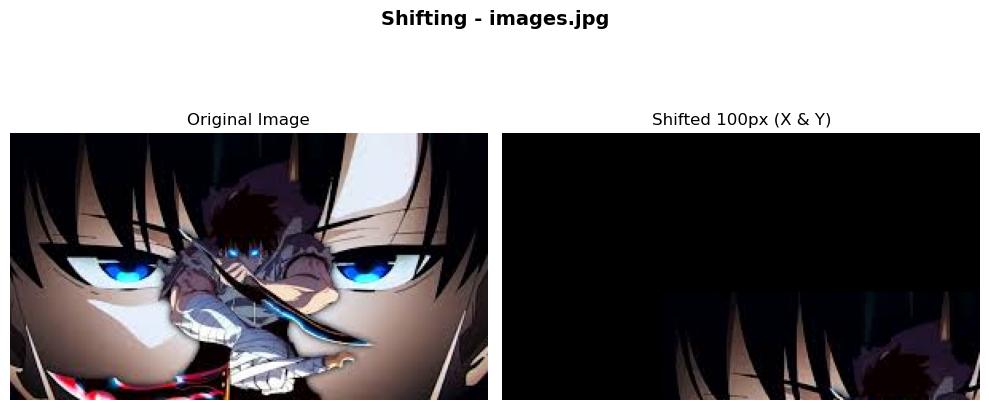

In [150]:
# e. Shift image on X and Y axis by 100 pixels
img5 = cv2.imread(os.path.join(img_dir, img_files[4]))
rows, cols = img5.shape[:2]
M = np.float32([[1, 0, 100], [0, 1, 100]])
shifted = cv2.warpAffine(img5, M, (cols, rows))

show_before_after(
    title=f"Shifting - {img_files[4]}",
    original=img5,
    transformed=shifted,
    after_title="Shifted 100px (X & Y)"
)

# 4️⃣ Splitting the channel of Video (10 Marks)
Choose any video and process it by splitting the 3 channels and display all the 3 channels.  

In [151]:
# Loading the video (update the path accordingly)
video_path = r"C:\Users\VICTUS\OneDrive\Desktop\PGA 28 WE\DL & AI Exam\bikes-1280x720-1 (1).mp4"
cap = cv2.VideoCapture(video_path)

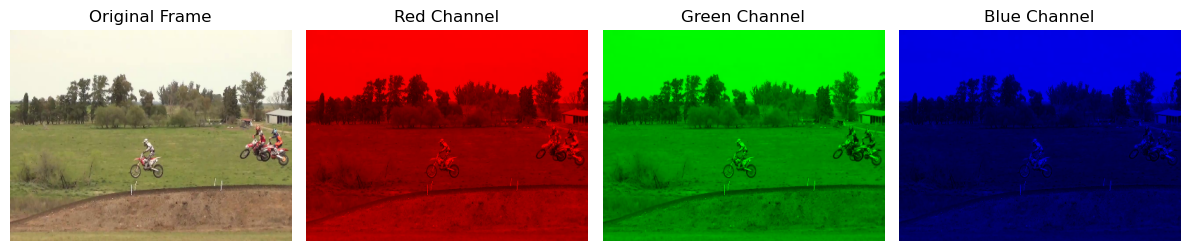

In [152]:
# Checking if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Read the first frame
    ret, frame = cap.read()
    if ret:
        # Resize for display if too large
        frame = cv2.resize(frame, (400, 300))

        # Split into B, G, R channels
        B, G, R = cv2.split(frame)

        # Convert single channels to 3-channel format for display
        blank = np.zeros_like(B)
        red_img   = cv2.merge([blank, blank, R])
        green_img = cv2.merge([blank, G, blank])
        blue_img  = cv2.merge([B, blank, blank])

        # Plot original and channel images
        titles = ['Original Frame', 'Red Channel', 'Green Channel', 'Blue Channel']
        imgs   = [frame, red_img, green_img, blue_img]

        plt.figure(figsize=(12, 6))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    else:
        print("Error: Could not read frame.")

    cap.release()